<a href="https://colab.research.google.com/github/LuluW8071/Cataract-Normal-Eye-Classification/blob/main/Multiple_Eye_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Token

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload kaggle.json from kaggle_account > your_profile > API section > Create new token
files.upload();

Saving kaggle.json to kaggle.json


## Download Dataset and Extract

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:14<00:00, 193MB/s]
100% 1.62G/1.62G [00:14<00:00, 117MB/s]


In [4]:
from tqdm.notebook import tqdm
import zipfile

zip_file_path = 'ocular-disease-recognition-odir5k.zip'
extracted_dir = 'dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc='Extracting'):
        zip_ref.extract(file, extracted_dir)

print(f"Dataset extracted to {extracted_dir}")

Extracting:   0%|          | 0/14394 [00:00<?, ?it/s]

Dataset extracted to dataset


In [5]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import os

In [6]:
df = pd.read_csv("dataset/full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
df.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1796,2638,48,Male,2638_left.jpg,2638_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2638_right.jpg
3698,587,53,Male,587_left.jpg,587_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",587_left.jpg
2984,4437,50,Male,4437_left.jpg,4437_right.jpg,moderate non proliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",4437_right.jpg
2066,2933,50,Female,2933_left.jpg,2933_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2933_right.jpg
2182,3062,83,Female,3062_left.jpg,3062_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3062_right.jpg


In [24]:
df['labels'] = df['labels'].str.replace('[', '', regex=True).str.replace(']', '', regex=True)
df['labels'] = df['labels'].str.replace("'", '', regex=True)

df['labels']

0       N
1       N
2       D
3       D
4       D
       ..
6387    D
6388    D
6389    D
6390    D
6391    H
Name: labels, Length: 6392, dtype: object

In [25]:
# Left_Eye_Dataset
left_normal = df.loc[(df.labels == 'N')]["Left-Fundus"]
left_diabetes = df.loc[(df.labels == 'D')]["Left-Fundus"]
left_glaucoma = df.loc[(df.labels == 'G')]["Left-Fundus"]
left_cataract = df.loc[(df.labels == 'C')]["Left-Fundus"]
left_age_related = df.loc[(df.labels == 'A')]["Left-Fundus"]
left_hypertension = df.loc[(df.labels == 'H')]["Left-Fundus"]
left_myopia = df.loc[(df.labels == 'M')]["Left-Fundus"]
left_other = df.loc[(df.labels == 'O')]["Left-Fundus"]

# Right_Eye_Dataset
right_normal = df.loc[(df.labels == 'N')]["Right-Fundus"]
right_diabetes = df.loc[(df.labels == 'D')]["Right-Fundus"]
right_glaucoma = df.loc[(df.labels == 'G')]["Right-Fundus"]
right_cataract = df.loc[(df.labels == 'C')]["Right-Fundus"]
right_age_related = df.loc[(df.labels == 'A')]["Right-Fundus"]
right_hypertension = df.loc[(df.labels == 'H')]["Right-Fundus"]
right_myopia = df.loc[(df.labels == 'M')]["Right-Fundus"]
right_other = df.loc[(df.labels == 'O')]["Right-Fundus"]

In [26]:
# Concatenate arrays of left and right images dataset into one
normal = np.concatenate((left_normal, right_normal), axis = 0)
diabetes = np.concatenate((left_diabetes, right_diabetes), axis = 0)
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis = 0)
cataract = np.concatenate((left_cataract, right_cataract), axis= 0)
age_related = np.concatenate((left_age_related, right_age_related), axis= 0)
hypertension = np.concatenate((left_hypertension, right_hypertension), axis= 0)
myopia = np.concatenate((left_myopia, right_myopia), axis= 0)
other = np.concatenate((left_other, right_other), axis= 0)

In [27]:
normal[:5], other[:5]

(array(['0_left.jpg', '1_left.jpg', '8_left.jpg', '10_left.jpg',
        '29_left.jpg'], dtype=object),
 array(['9_left.jpg', '14_left.jpg', '15_left.jpg', '17_left.jpg',
        '21_left.jpg'], dtype=object))

In [29]:
print("Length of Normal category:", len(normal))
print("Length of Diabetes category:", len(diabetes))
print("Length of Glaucoma category:", len(glaucoma))
print("Length of Cataract category:", len(cataract))
print("Length of Age-related category:", len(age_related))
print("Length of Hypertension category:", len(hypertension))
print("Length of Myopia category:", len(myopia))
print("Length of Other category:", len(other))

print("Combined:", len(normal) + len(diabetes) + len(glaucoma) + len(cataract) + len(age_related) + len(hypertension) + len(myopia) + len(other))

Length of Normal category: 5746
Length of Diabetes category: 3216
Length of Glaucoma category: 568
Length of Cataract category: 586
Length of Age-related category: 532
Length of Hypertension category: 256
Length of Myopia category: 464
Length of Other category: 1416
Combined: 12784


Lets even out the data distribution so we dont see biasness towards prediction of normal, diabetes, and other

In [9]:
normal = np.random.choice(normal, size=1000, replace=True)
diabetes = np.random.choice(diabetes, size=750, replace=True)
other = np.random.choice(other, size=800, replace=True)

len(normal), len(diabetes), len(other)

(1000, 750, 800)

## PyTorch

In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


### PyTorch DataLoader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, image_category, label, dataset_dir, image_size):
        self.image_category = image_category
        self.label = label
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.data = self.create_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

    def create_dataset(self):
        dataset = []
        dataset_label = []
        for img in tqdm(self.image_category):
            image_path = os.path.join(self.dataset_dir, img)
            try:
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (self.image_size, self.image_size))
            except:
                continue

            dataset.append([np.array(image), np.array(self.label)])
        random.shuffle(dataset)
        return dataset

In [12]:
from tqdm.auto import tqdm
path = "dataset/preprocessed_images/"

dataset_normal = CustomDataset(image_category = normal,
                               label = 0,
                               dataset_dir = path,
                               image_size = 224)

dataset_diabetes = CustomDataset(diabetes, 1, path, 224)
dataset_glaucoma = CustomDataset(glaucoma, 2, path, 224)
dataset_cataract = CustomDataset(cataract, 3, path, 224)
# dataset_age_related = CustomDataset(age_related, 4, path, 224)
dataset_hypertension = CustomDataset(hypertension, 4, path, 224)
dataset_myopia = CustomDataset(myopia, 5, path, 224)
dataset_other = CustomDataset(other, 6, path, 224)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [13]:
dataset = ConcatDataset([dataset_normal, dataset_diabetes, dataset_glaucoma,
                         dataset_cataract, dataset_hypertension,
                         dataset_myopia, dataset_other])

print("Combined dataset length:", len(dataset))

Combined dataset length: 5022


In [14]:
# Function to label the eye_defect
def target(category):
  if category == 0:
    return "Normal"
  elif category == 1:
    return "Diabetes"
  elif category == 2:
    return "Glaucoma"
  elif category == 3:
    return "Cataract"
  # elif category == 4:
  #   return "Age_related"
  elif category == 4:
    return "Hypertension"
  elif category == 5:
    return "Myopia"
  else:
    return "Other"

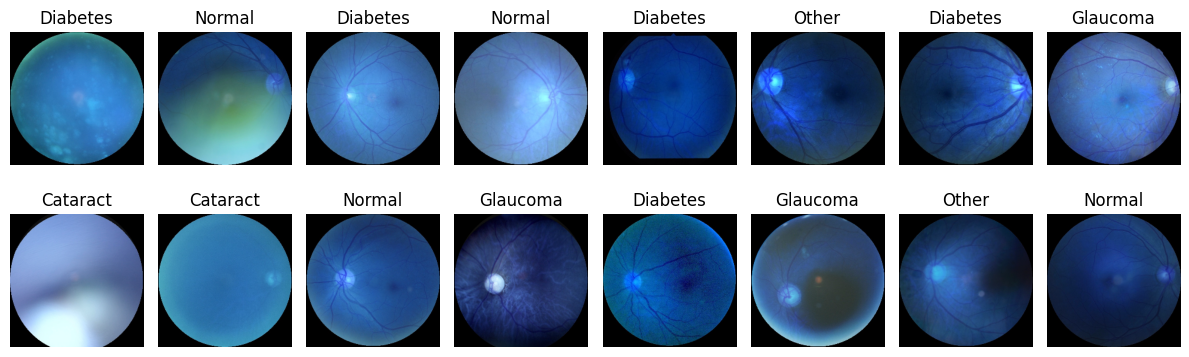

In [15]:
plt.figure(figsize=(12, 4))
rows, cols = 2, 8

for i in range(1, rows*cols + 1):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]

  label = target(category)

  plt.subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(label)
  plt.axis(False);
plt.tight_layout()

In [16]:
dataset[0][0], dataset[0][0].shape

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 (224, 224, 3))

## Train and Test Split

In [17]:
X = np.array([i[0] for i in dataset]).reshape(-1, 224, 224, 3)
y = np.array([i[1] for i in dataset])

In [18]:
# Conversion of image arrays and labels to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X[0], y[:10]

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([0, 

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    random_state = 42)

len(X_train), len(X_test), y_train[:10]

(3766, 1256, tensor([4, 1, 0, 4, 0, 6, 6, 3, 0, 3]))

In [20]:
X_train.shape

torch.Size([3766, 224, 224, 3])

In [21]:
# Permute the color channel index to front
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [22]:
# Turn datasets into batches
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)      # Shuffle false cuz already shuffled using sklearn->train_test_spilt

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(59, 20)

In [23]:
# Checking shape of train_images and train_labels dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

## VGG BaseModel with added `Conv2d` Layers

In [24]:
class CataractModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super(CataractModel, self).__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(hidden_units)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # nn.Dropout(0.5),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(4 * hidden_units)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(4 *hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(output_shape)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * output_shape, 2056),
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout for regularization
        nn.Linear(2056, 512),
        nn.ReLU(),
        # nn.Dropout(0.5),
        nn.Linear(512, output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x

## `ResNet50` Replica Architecture

In [54]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 3)
        self.layer2 = self.make_layer(ResidualBlock, 256, 4, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 1024, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024 * 4, num_classes)

    def make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels * 4),
            )
        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [55]:
# model = CataractModel(3, 64, 7).to(device)   # (3, 10, 8) -> (Color_channel, hidden_units, output_shape)
model = ResNet50(7)
model, next(model.parameters()).device

(ResNet50(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_siz

## Train and Test Dataloaders

In [27]:
!pip install torchmetrics

In [40]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "multiclass",
                                 num_classes = 7).to(device)

In [56]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [57]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  train_losses = []
  train_accuracies = []
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  train_losses.append(train_loss.item())
  train_accuracies.append(train_acc.item())
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')
  return train_losses, train_accuracies

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  test_losses = []
  test_accuracies = []

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y,
                                        test_pred.argmax(dim = 1)) * 100
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')
  return test_losses, test_accuracies

In [91]:
torch.manual_seed(42)

epochs = 10
train_losses_history = []
train_accuracies_history = []
test_losses_history = []
test_accuracies_history = []

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_losses, train_accuracies = train_step(model, train_dataloader, loss_fn, optimizer,
                                              torchmetrics_accuracy, device)
  test_losses, test_accuracies = test_step(model, test_dataloader, loss_fn, optimizer,
                                           torchmetrics_accuracy, device)
  # Calculate avg. loss and accuracy
  avg_train_loss = sum(train_losses) / len(train_losses)
  avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  avg_test_loss = sum(test_losses) / len(test_losses)
  avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

  train_losses_history.append(avg_train_loss)
  train_accuracies_history.append(avg_train_accuracy)
  test_losses_history.append(avg_test_loss)
  test_accuracies_history.append(avg_test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.2170 ---- Train acc: 51.42%
Test loss: 1.5234 ---- Test acc: 42.41%
Epoch: 1
Train loss: 1.1633 ---- Train acc: 54.30%
Test loss: 1.5604 ---- Test acc: 42.09%
Epoch: 2
Train loss: 1.1146 ---- Train acc: 56.77%
Test loss: 1.6005 ---- Test acc: 43.91%
Epoch: 3
Train loss: 1.1192 ---- Train acc: 55.89%
Test loss: 1.5039 ---- Test acc: 45.98%
Epoch: 4
Train loss: 1.1710 ---- Train acc: 54.33%
Test loss: 1.5518 ---- Test acc: 44.91%
Epoch: 5
Train loss: 1.0467 ---- Train acc: 59.91%
Test loss: 1.5844 ---- Test acc: 47.52%
Epoch: 6
Train loss: 0.8717 ---- Train acc: 68.10%
Test loss: 1.7197 ---- Test acc: 48.25%
Epoch: 7
Train loss: 0.8820 ---- Train acc: 67.50%
Test loss: 1.8094 ---- Test acc: 49.47%
Epoch: 8
Train loss: 0.9269 ---- Train acc: 66.55%
Test loss: 1.5591 ---- Test acc: 49.52%
Epoch: 9
Train loss: 0.9630 ---- Train acc: 65.27%
Test loss: 1.6022 ---- Test acc: 51.36%


## Plot loss curves and accuracy curves

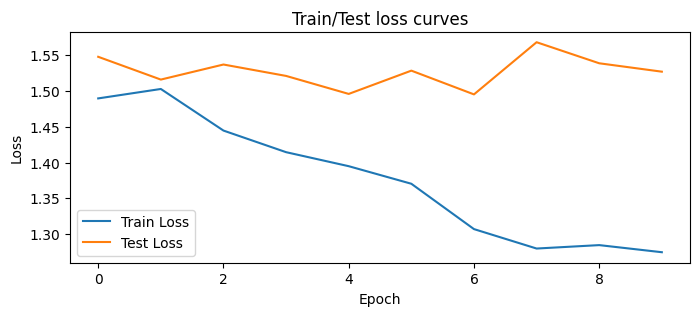

In [84]:
# Plot loss curves
epoch = np.arange(0, len(train_losses_history))

plt.figure(figsize=(8, 3))
plt.plot(epoch, train_losses_history, label="Train Loss")
plt.plot(epoch, test_losses_history, label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

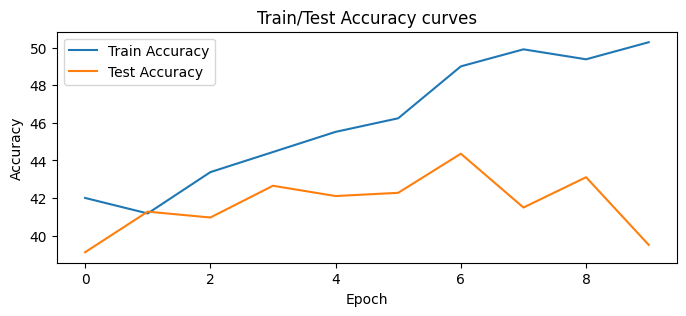

In [85]:
# Plot accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(epoch, train_accuracies_history, label="Train Accuracy")
plt.plot(epoch, test_accuracies_history, label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

## Make Predictions

In [62]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [63]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [86]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [87]:
# Make Predictions
pred_probs = make_predictions(model,
                              test_samples,
                              device)

# Convert prediction proabbilities to labels
pred_classes = pred_probs.argmax(dim = 1)
print(pred_classes, test_labels, sep = '\n')

tensor([3, 6, 6, 6, 5, 3, 4, 1, 4, 6, 6, 2, 6, 1, 6, 6, 3, 0, 3, 5])
[tensor(3), tensor(1), tensor(3), tensor(6), tensor(5), tensor(6), tensor(0), tensor(6), tensor(6), tensor(4), tensor(4), tensor(2), tensor(4), tensor(1), tensor(0), tensor(0), tensor(3), tensor(2), tensor(2), tensor(5)]


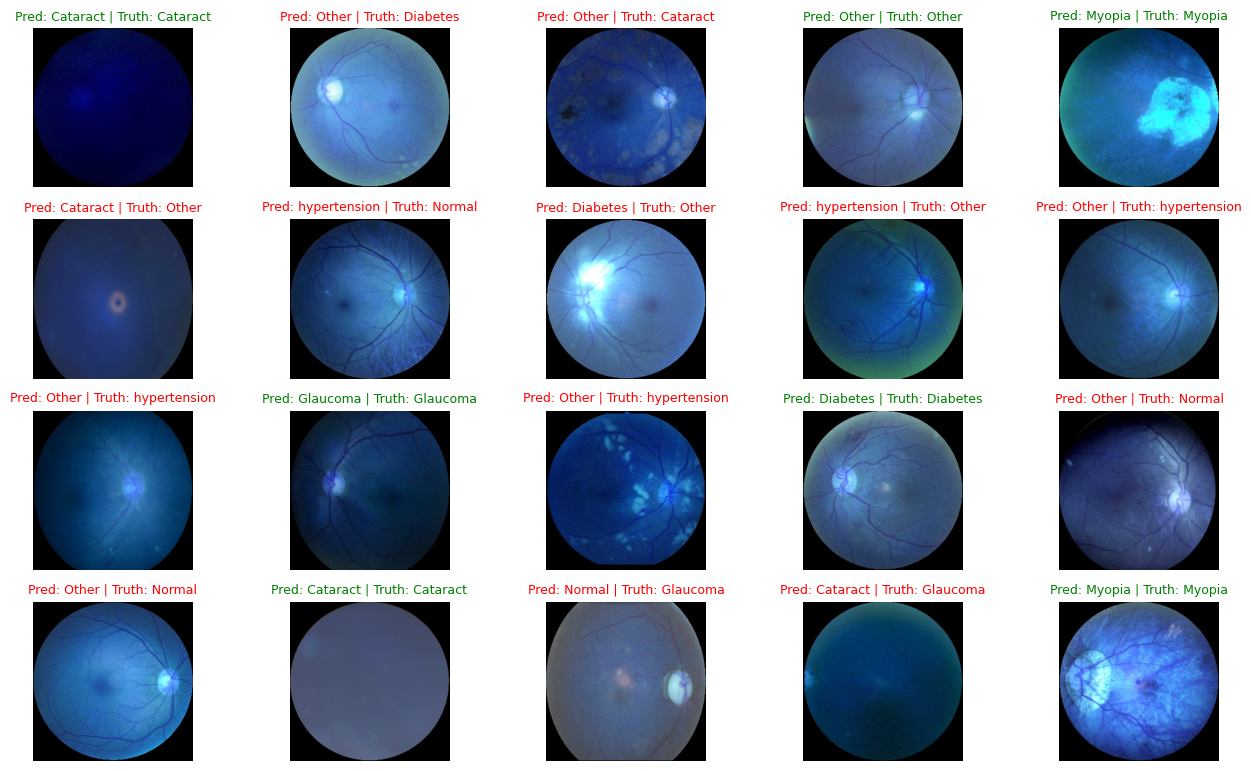

In [88]:
# Plot predictions
plt.figure(figsize=(16, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'hypertension', 'Myopia', 'Other'])
  plt.subplot(nrows, ncols, i + 1)
  # Convert PyTorch tensor to NumPy array
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0  # Normalize pixel values to [0, 1]
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check equality between pred and truth and change color of title
  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False)
plt.show()


## Plot Confusion Matrix

In [89]:
# Make prediciton with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc = "Making predictions...\t"):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1 )
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...	:   0%|          | 0/20 [00:00<?, ?it/s]

(tensor([0, 2, 4, 0, 3, 3, 3, 6, 6, 3]), 1256)

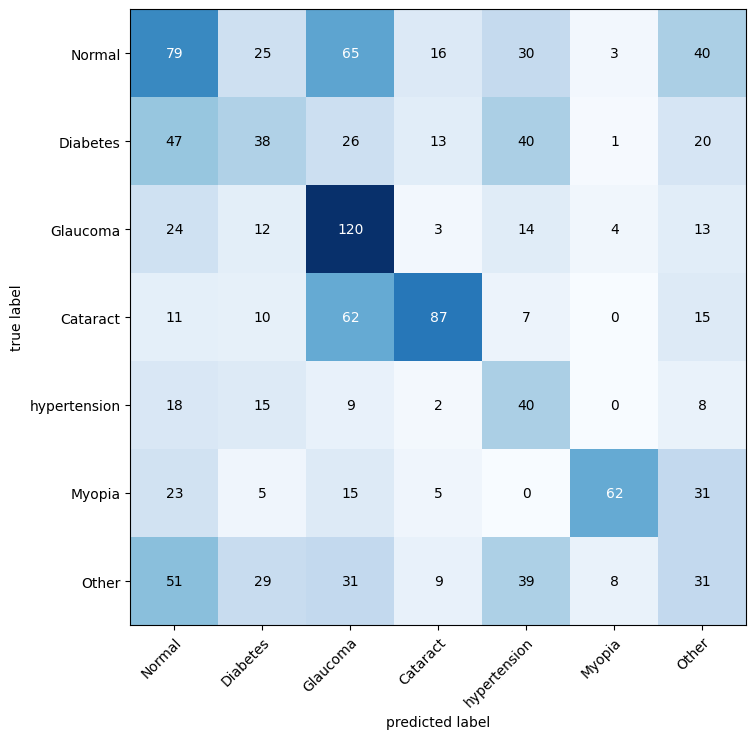

In [90]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name), task = 'multiclass')
# print(y_pred_tensor, test_data.targets)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (12, 8)
);

## Saving and Loading Model

In [79]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "MultipleEyeDiseaseDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/MultipleEyeDiseaseDetectModel.pth


In [80]:
# loaded_model = CataractModel(3, 64, 7)
loaded_model = ResNet50(7)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")
# loaded_model = loaded_model.to('cpu')     # For model to load in cpu and check inference

Loaded model:
ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=

In [81]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

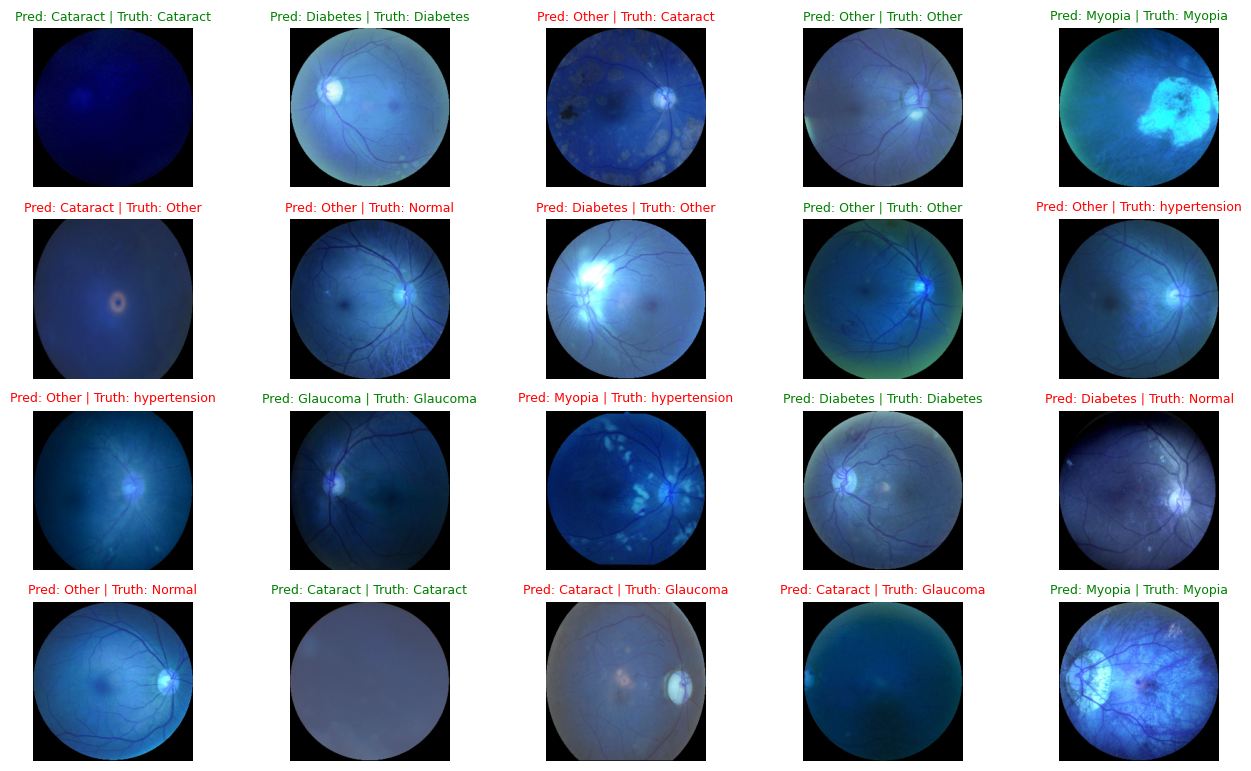

In [82]:
plt.figure(figsize=(16, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'hypertension', 'Myopia', 'Other'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)

  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);